<a href="https://colab.research.google.com/github/sujith2303/ML_From_Scratch/blob/main/TODOs_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normal + GPU optimized Code
1. RoPE    --> Done
2. ADAM optimizer
3. MLA + KV cache, kv cache in attention, linear layers
4. Flash Attention
5. Cuda basics
6. Diffusion models
7. tokenizer implementations
8. WithRes and without Res  --> Done
9. ResNet vs deepseek mhc

In [ ]:
import torch
import torch.nn as nn

In [ ]:
## plot RoPE for different values and see the convergence rule
## compare sinusoidal vs RoPE
# even_positions = x[...,:,0::2]
# odd_positions  = x[...,:,1::2]

class RoPE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.theta_factor = kwargs.get("theta_factor",10_000)


    def forward(self, x):
        b, s, d      = x.shape  ## b * s *d
        device       = x.device

        pos          = torch.arange(s).unsqueeze(1)
        i            = torch.arange(d//2).unsqueeze(0)
        angles       = pos/ (self.theta_factor ** (2*i/d))

        x[...,:,0::2],x[...,:,1::2] = x[...,:,0::2] * torch.cos(angles) - x[...,:,1::2] * torch.sin(angles),x[...,:,0::2] * torch.sin(angles) + x[...,:,1::2] * torch.cos(angles)

        return x


In [ ]:
class RoPE(nn.Module):
    def __init__(self, dim, theta_factor=10_000.0):
        super().__init__()
        self.dim = dim
        self.theta_factor = theta_factor

        # Precompute frequencies: [1, theta^{-2/d}, theta^{-4/d}, ..., theta^{-(d-2)/d}]
        inv_freq = 1.0 / (theta_factor ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
        self.register_buffer("inv_freq", inv_freq)  # Shape: (dim//2,)

    def forward(self, x):
        # x: [batch, seq_len, dim]
        b, s, d = x.shape
        device = x.device

        assert d == self.dim, f"Input dimension {d} doesn't match RoPE dim {self.dim}"

        # Create position indices: [0, 1, ..., s-1] -> (s, 1)
        pos = torch.arange(s, device=device).unsqueeze(1)  # (s, 1)

        # Angles: pos * inv_freq -> (s, dim//2)
        angles = pos * self.inv_freq  # (s, dim//2)

        # Expand for sin/cos application
        cos_angles = angles.cos().unsqueeze(0)  # (1, s, dim//2)
        sin_angles = angles.sin().unsqueeze(0)  # (1, s, dim//2)

        # Split x into even and odd parts
        x_even = x[..., 0::2]   # (b, s, dim//2)
        x_odd  = x[..., 1::2]   # (b, s, dim//2)

        # Apply rotation: [x_even * cos - x_odd * sin, x_even * sin + x_odd * cos]
        x_rotated_even =  x_even * cos_angles - x_odd * sin_angles
        x_rotated_odd  =  x_even * sin_angles + x_odd * cos_angles

        # Interleave back
        x_rotated = torch.stack((x_rotated_even, x_rotated_odd), dim=-1)  # (b, s, dim//2, 2)
        x_rotated = x_rotated.flatten(-2)  # (b, s, dim)

        return x_rotated

In [ ]:
x = torch.randn(1,1_00_000,864)
r = RoPE(864)

In [ ]:
import time
a = time.time()
r(x)
print(time.time()-a)

2.110459566116333


In [ ]:
r(x)

tensor([[[ 0.0910, -0.7834,  1.4016,  ..., -0.6982, -0.1647,  0.0948],
         [-1.2312,  0.8008,  0.8015,  ...,  0.3385, -0.6373, -1.4966],
         [ 0.9750, -1.3813,  0.7346,  ...,  0.1699,  1.1279,  0.6638],
         ...,
         [-0.4958,  0.0198, -1.5695,  ...,  0.1597,  0.7557, -0.4927],
         [-0.2588, -0.0762,  0.6890,  ...,  0.9600,  0.4266,  0.9757],
         [ 0.0515, -3.4495,  0.6556,  ..., -0.2080,  0.1829, -0.7769]]])

## Adam Optimizer

## MLA

# DeepResNets vs Normal network

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
input_size = 784 # 28x28 for MNIST
hidden_size = 784 # Using a hidden size equal to input size for simplicity
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# 3. MNIST dataset loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or numpy.ndarray to FloatTensor and scales values to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 4. Neural Network model (without residual connections)
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_intermediate_blocks=4):
        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        layers = []
        # First layer: input_dim -> hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # Intermediate layers: hidden_dim -> hidden_dim
        for _ in range(num_intermediate_blocks):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# ResNet model (with simple residual connections)
class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5): # num_blocks total linear layers
        super(ResNet, self).__init__()
        self.input_dim = input_dim

        # First layer (not a residual block): input_dim -> hidden_dim
        self.first_linear = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU() # Define ReLU once

        # Subsequent residual blocks: hidden_dim -> hidden_dim
        self.residual_linear_layers = nn.ModuleList()
        for _ in range(num_blocks - 1): # Create num_blocks-1 residual linear layers
            self.residual_linear_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image

        # First layer
        x = self.first_linear(x)
        x = self.relu(x)

        # Residual layers
        for res_layer in self.residual_linear_layers:
            identity = x # Store input before the linear layer
            out = res_layer(x)
            x = self.relu(out + identity) # Add identity and then apply ReLU

        # Final output layer
        out = self.output_layer(x)
        return out

# # Instantiate models
# model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# res_model = ResNet(input_size, hidden_size, num_classes).to(device)

# Define a training function to avoid code duplication
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                # print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses

Using device: cuda


In [ ]:
# model_layers_losses = []  ## model type, num layers, their losses
experiments = [50,100,150]
epochs = 20
for layers in experiments:
    model = NeuralNet(input_size, hidden_size, num_classes,num_intermediate_blocks=layers-1).to(device)
    res_model = ResNet(input_size, hidden_size, num_classes,num_blocks=layers).to(device)
    model_loss = train(model,epochs)
    res_loss   = train(res_model,epochs)
    model_layers_losses.append(("model", layers, model_loss))
    model_layers_losses.append(("res_model", layers, res_loss))


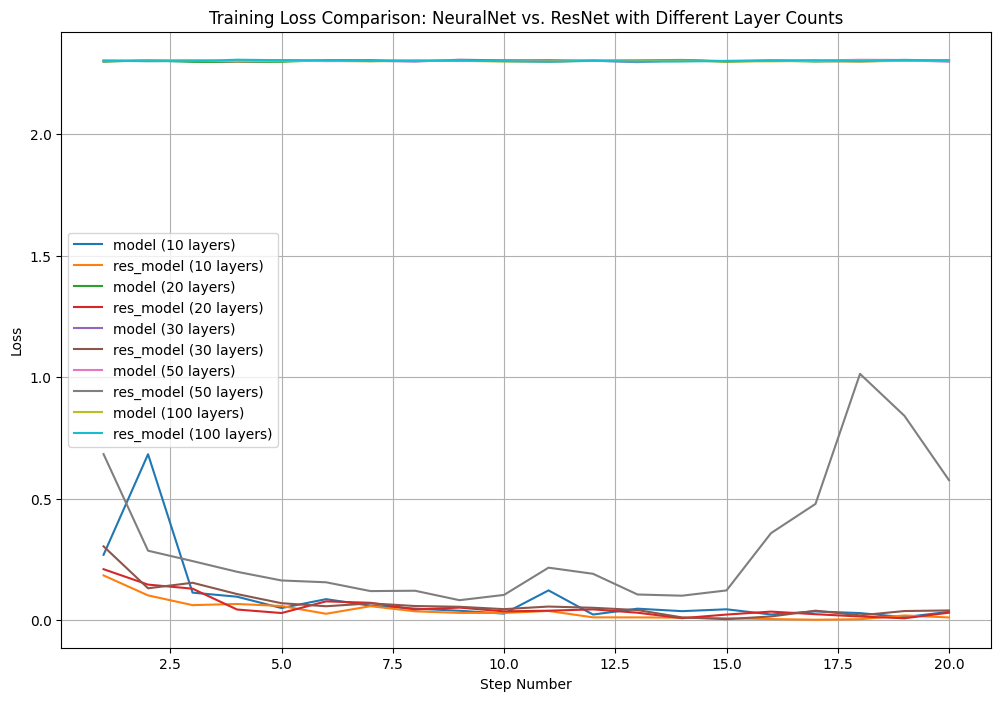

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Training Loss Comparison: NeuralNet vs. ResNet with Different Layer Counts")
plt.xlabel("Step Number")
plt.ylabel("Loss")
plt.grid(True)

for model_type, num_layers, loss_data in model_layers_losses:
    if loss_data: # Ensure there is data to plot
        loss_values = [item[0] for item in loss_data]
        step_numbers = [item[1] for item in loss_data]
        plt.plot(step_numbers, loss_values, label=f'{model_type} ({num_layers} layers)')

plt.legend()
plt.show()

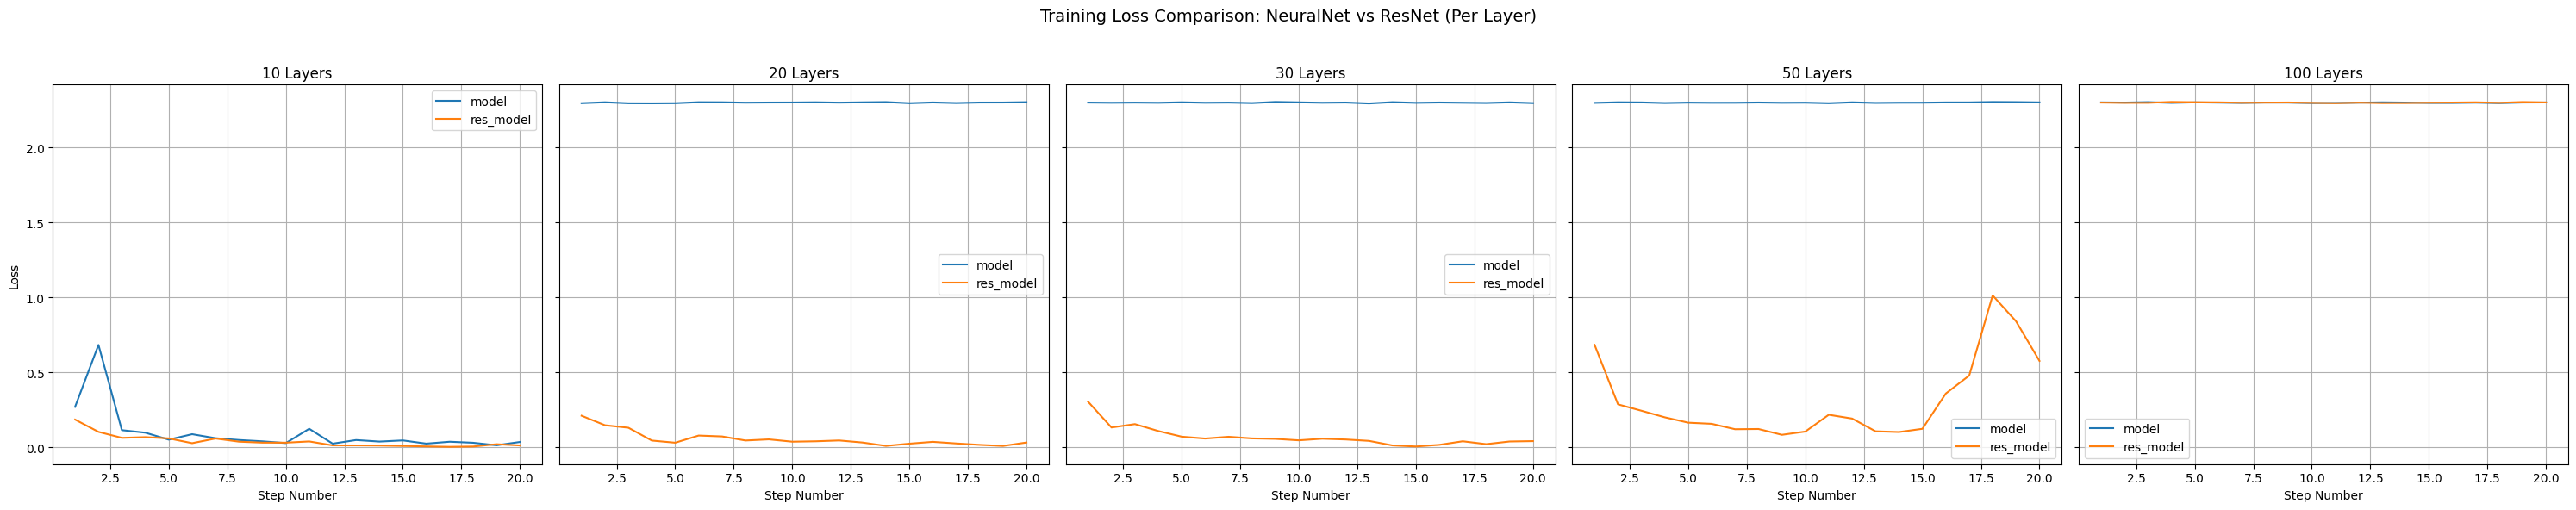

In [12]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Group data by number of layers
layer_groups = defaultdict(list)
for model_type, num_layers, loss_data in model_layers_losses:
    if loss_data:
        layer_groups[num_layers].append((model_type, loss_data))

num_layers_list = sorted(layer_groups.keys())
num_plots = len(num_layers_list)

fig, axes = plt.subplots(
    1, num_plots,
    figsize=(6 * num_plots, 6),
    sharey=True
)

# If only one subplot, make axes iterable
if num_plots == 1:
    axes = [axes]

for ax, num_layers in zip(axes, num_layers_list):
    for model_type, loss_data in layer_groups[num_layers]:
        loss_values = [item[0] for item in loss_data]
        step_numbers = [item[1] for item in loss_data]

        ax.plot(
            step_numbers,
            loss_values,
            label=model_type
        )

    ax.set_title(f"{num_layers} Layers")
    ax.set_xlabel("Step Number")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Loss")
fig.suptitle(
    "Training Loss Comparison: NeuralNet vs ResNet (Per Layer)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# look into layers of model and res_model for an input and do some analysis

# ResNet vs Deepseek's MHC